In [1]:
#Import MNIST dataset with torchvision

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import tqdm
from typing import Type
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#import torchvision.transforms as transforms

# Loading the dataset

In [2]:
# Display mnist image with a tensor as an input
def show_image(img):
    npimg = img.squeeze(0).numpy()
    plt.imshow(np.transpose(npimg), cmap = 'grey')#, (1, 2, 0)), interpolation='nearest')

In [3]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [4]:
emnist_dataset = torchvision.datasets.EMNIST(root='./data', split='letters',  download=True, transform=transforms)
emnist_loader = DataLoader(emnist_dataset, batch_size=64, shuffle=True)

In [5]:
#Print label number
print(emnist_dataset[0][1])

23


torch.Size([64, 1, 28, 28])
torch.Size([64])


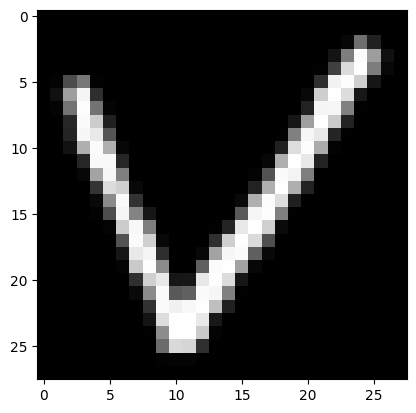

In [6]:
for i, (images, labels) in enumerate(emnist_loader):
    print(images.shape)
    print(labels.shape)
    show_image(images[0])
    break

In [7]:
# Calculate mean and std of the dataset
mean = emnist_dataset.data.float().mean()/255
std = emnist_dataset.data.float().std()/255
print('mean:', mean)
print('std:', std)

mean: tensor(0.1722)
std: tensor(0.3309)


In [8]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std,)),
    torchvision.transforms.RandomCrop(
        size = 28,
        padding = 2,
        padding_mode = 'reflect'
    ),
    torchvision.transforms.RandomRotation(
        degrees = 15
    )
])

In [9]:
emnist_dataset = torchvision.datasets.EMNIST(root='./data', split='letters',  download=True, transform=transforms)
emnist_loader = DataLoader(emnist_dataset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


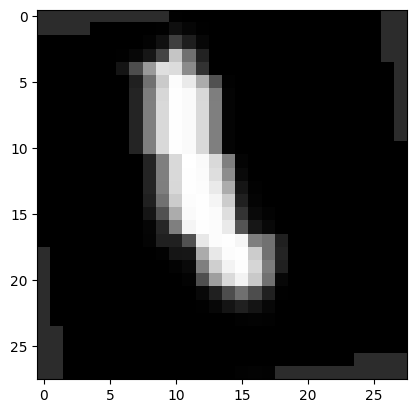

In [10]:
for i, (images, labels) in enumerate(emnist_loader):
    print(images.shape)
    print(labels.shape)
    show_image(images[0])
    break

In [11]:
emnist_trainset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=True, download=True, transform=transforms)
emnist_testset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=False, download=True, transform=transforms)

# Implementing ResNet-18

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, 
                 in_channels : int, 
                 out_channels : int, 
                 stride : int = 1, 
                   ) -> None:
        super(ResidualBlock, self).__init__()
        
          
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 :
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=1, 
                    stride=stride, 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )
        else :
            self.downsample = nn.Identity()

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        
        return out

In [13]:
class ResNet_18(nn.Module):
    def __init__(self,
                 num_classes : int = 62, 
                 ResidualBlock : Type[nn.Module] = ResidualBlock
                 ) -> None :
        super(ResNet_18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.num_classes = num_classes

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1
        )

        # Residual layers
        self.layer1 = nn.Sequential(
            ResidualBlock(
                in_channels = 64, 
                out_channels = 64,
                stride = 1,),
            ResidualBlock(
                in_channels = 64, 
                out_channels = 64,
                stride = 1,)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(
                in_channels = 64, 
                out_channels = 128,
                stride = 2, ),
            ResidualBlock(
                in_channels = 128, 
                out_channels = 128,
                stride = 1,)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(
                in_channels = 128, 
                out_channels = 256,
                stride = 2, ),
            ResidualBlock(
                in_channels = 256, 
                out_channels = 256,
                stride = 1,)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(
                in_channels = 256, 
                out_channels = 512,
                stride = 2, ),
            ResidualBlock(
                in_channels = 512, 
                out_channels = 512,
                stride = 1,)
        )

        self.adaptative_pool = nn.AdaptiveAvgPool2d((1,1))

        self.classify1 = nn.Linear(512, 256)
        self.classify2 = nn.Linear(256, self.num_classes)

    def forward(self, x : torch.Tensor()) -> torch.Tensor :
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #for classification 
        x = self.adaptative_pool(x)
        x = torch.flatten(x, 1)
        x = self.classify1(x)
        x = self.classify2(x)
        return x

## The simple CNN model


In [14]:
class MNIST_classifier(nn.Module):
    def __init__(self):
        super(MNIST_classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride = 2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride = 2, padding=1)
        #self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride = 3)
        
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(576, 10)

        self.fc2 = nn.Linear(256, 10)

        

        self.max_pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.max_pool(F.relu(self.conv2(x))))
        x = self.conv_drop(x)
        #print(x.shape)
        x = x.view(-1, 576)
    
        #print(x.shape)
        x = self.fc1(x)
        #x = F.dropout(x, training=self.training)
        #x = F.relu(x)
        return x
    

    #FOR MAC 


## Simple Linear Model

In [15]:
"""
 inputs = Input(shape=(784,))
  x = Dense(256, activation='relu')(inputs)
  x = Dense(128, activation='relu')(x)
  outputs = Dense(len(LABELS), activation='softmax')(x)

"""

class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 47)

    def forward(self, x):
        x=torch.flatten(x, 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.softmax(self.linear3(x))
        return x

# Training

In [24]:
device = torch.device('mps')

In [29]:
def train(model, train_loader, optimizer, epoch, critetion, acc_dict, loss_dict) :
    model.train()
    total_loss = 0 
    total_acc = 0
    with tqdm.tqdm(range(len(train_loader))) as pbar:
        
        for X,Y in train_loader:
            X,Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            output = model(X)#.to(device)
            
            loss = critetion(output, Y)
            pred = output.argmax(dim=1, keepdim=True)
            #print(X.shape ,output.shape, Y.shape, pred.shape)
            #print((pred.squeeze(0) == Y).sum())
            #pred = np.array(pred.item().cpu())
            #Y = np.array(Y.unsqueeze(0).cpu())
            correct = pred.eq(Y.view_as(pred)).sum().item()
            total_acc += correct/len(X)
            #print(pred, Y)

            #print((pred.squeeze(0) == Y).sum().item()/len(X))
            total_loss += loss.item()
            loss.backward()

            optimizer.step()    
            pbar.update(1)
    
    acc_dict[epoch] = [total_acc/len(train_loader)*100]
    loss_dict[epoch] = [total_loss/len(train_loader)]
    print(f'[TRAIN] : For epoch {epoch}, the loss is {total_loss/len(train_loader)} and the accuracy is {total_acc/len(train_loader)*100}')

In [30]:
def test(model, test_loader , epoch, criterion, best_loss, acc_dict, loss_dict):
    model.eval()
    with torch.no_grad():
        total_acc = 0 
        total_loss = 0 
        with tqdm.tqdm(range(len(test_loader))) as pbar:
            for X,Y in test_loader : 
                X,Y = X.to(device), Y.to(device)
                
                output = model(X)#.to(device)

                loss = criterion(output, Y)
                pred = output.argmax(dim=1, keepdim=True)

                correct = pred.eq(Y.view_as(pred)).sum().item()
                #total_loss += loss.item()
                total_acc += correct/len(X)
                total_loss += loss.item()
                pbar.update(1)

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    torch.save(model.state_dict(), 'model/ResNet-18/best_model.pth')

        acc_dict[epoch].append(total_acc/len(test_loader)*100)
        loss_dict[epoch].append(total_loss/len(test_loader))
        print(f'[TEST] : For epoch {epoch}, the loss is {total_loss/len(test_loader)} and the accuracy is {total_acc*100/len(test_loader)}')

        return best_loss


In [31]:
train_loader = DataLoader(emnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(emnist_testset, batch_size=256, shuffle=True)

#model = SimpleLinearModel().to(device)
model = ResNet_18(num_classes=len(emnist_testset.classes)).to(device)
#model = MNIST_classifier().to(device)

In [32]:
acc_dict = {}
loss_dict = {}
criterion = F.cross_entropy
optimizer = torch.optim.AdamW(model.parameters(), lr=10e-3)#.to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epochs = 20
best_loss = 1000
for epoch in range(epochs) : 
    train(model, train_loader, optimizer, epoch, criterion, acc_dict, loss_dict)
    best_loss = test(model, test_loader, epoch, criterion, best_loss, acc_dict, loss_dict)
    scheduler.step()

100%|██████████| 2727/2727 [05:08<00:00,  8.83it/s]


[TRAIN] : For epoch 0, the loss is 0.7192013703797561 and the accuracy is 77.47604667264973


100%|██████████| 455/455 [00:38<00:00, 11.67it/s]


[TEST] : For epoch 0, the loss is 0.51479364830059 and the accuracy is 82.40995115995115


100%|██████████| 2727/2727 [05:04<00:00,  8.96it/s]


[TRAIN] : For epoch 1, the loss is 0.46813117556183775 and the accuracy is 83.659838023276


100%|██████████| 455/455 [00:36<00:00, 12.30it/s]


[TEST] : For epoch 1, the loss is 0.47225671672559044 and the accuracy is 83.02222083472083


100%|██████████| 2727/2727 [04:55<00:00,  9.24it/s]


[TRAIN] : For epoch 2, the loss is 0.44280964646489795 and the accuracy is 84.32828000453554


100%|██████████| 455/455 [00:36<00:00, 12.51it/s]


[TEST] : For epoch 2, the loss is 0.42277260986003246 and the accuracy is 84.79564706127205


100%|██████████| 2727/2727 [04:58<00:00,  9.12it/s]


[TRAIN] : For epoch 3, the loss is 0.4292777565795946 and the accuracy is 84.71714838698782


100%|██████████| 455/455 [00:36<00:00, 12.40it/s]


[TEST] : For epoch 3, the loss is 0.4375796639002286 and the accuracy is 84.50238997113999


100%|██████████| 2727/2727 [04:54<00:00,  9.26it/s]


[TRAIN] : For epoch 4, the loss is 0.4199470804261777 and the accuracy is 85.02698405805494


100%|██████████| 455/455 [00:34<00:00, 13.05it/s]


[TEST] : For epoch 4, the loss is 0.4134730732047951 and the accuracy is 85.22360452047953


100%|██████████| 2727/2727 [04:46<00:00,  9.52it/s]


[TRAIN] : For epoch 5, the loss is 0.3507701971612223 and the accuracy is 86.91299571294849


100%|██████████| 455/455 [00:34<00:00, 13.11it/s]


[TEST] : For epoch 5, the loss is 0.34359126608450336 and the accuracy is 87.02749507437007


100%|██████████| 2727/2727 [04:46<00:00,  9.52it/s]


[TRAIN] : For epoch 6, the loss is 0.3413122102077251 and the accuracy is 87.09670925974177


100%|██████████| 455/455 [00:34<00:00, 13.14it/s]


[TEST] : For epoch 6, the loss is 0.3387635671175443 and the accuracy is 87.18104811854812


100%|██████████| 2727/2727 [04:46<00:00,  9.53it/s]


[TRAIN] : For epoch 7, the loss is 0.33710056499089347 and the accuracy is 87.24030708991953


100%|██████████| 455/455 [00:34<00:00, 13.28it/s]


[TEST] : For epoch 7, the loss is 0.33776930017130713 and the accuracy is 87.14682886557885


100%|██████████| 2727/2727 [04:47<00:00,  9.50it/s]


[TRAIN] : For epoch 8, the loss is 0.33408929522347003 and the accuracy is 87.31400963561269


100%|██████████| 455/455 [00:34<00:00, 13.30it/s]


[TEST] : For epoch 8, the loss is 0.3340543754808195 and the accuracy is 87.3187402874903


100%|██████████| 2727/2727 [04:51<00:00,  9.36it/s]


[TRAIN] : For epoch 9, the loss is 0.33203437415658227 and the accuracy is 87.35107200413023


100%|██████████| 455/455 [00:35<00:00, 12.75it/s]


[TEST] : For epoch 9, the loss is 0.33355020684200326 and the accuracy is 87.27590118215117


100%|██████████| 2727/2727 [04:57<00:00,  9.16it/s]


[TRAIN] : For epoch 10, the loss is 0.32344342456726877 and the accuracy is 87.60664100949569


100%|██████████| 455/455 [00:36<00:00, 12.55it/s]


[TEST] : For epoch 10, the loss is 0.32761503248424323 and the accuracy is 87.55441607004109


100%|██████████| 2727/2727 [04:48<00:00,  9.45it/s]


[TRAIN] : For epoch 11, the loss is 0.3216825916100912 and the accuracy is 87.66234011010751


100%|██████████| 455/455 [00:34<00:00, 13.11it/s]


[TEST] : For epoch 11, the loss is 0.3273737684055999 and the accuracy is 87.51356282606282


100%|██████████| 2727/2727 [04:51<00:00,  9.36it/s]


[TRAIN] : For epoch 12, the loss is 0.3210928969858416 and the accuracy is 87.69208198232104


100%|██████████| 455/455 [00:34<00:00, 13.15it/s]


[TEST] : For epoch 12, the loss is 0.3251973493741109 and the accuracy is 87.5737456987457


100%|██████████| 2727/2727 [04:47<00:00,  9.48it/s]


[TRAIN] : For epoch 13, the loss is 0.3203839519749992 and the accuracy is 87.70333036593134


100%|██████████| 455/455 [00:34<00:00, 13.23it/s]


[TEST] : For epoch 13, the loss is 0.32650094968932014 and the accuracy is 87.50713696026196


100%|██████████| 2727/2727 [04:46<00:00,  9.53it/s]


[TRAIN] : For epoch 14, the loss is 0.3198038452944565 and the accuracy is 87.70074444396194


100%|██████████| 455/455 [00:34<00:00, 13.16it/s]


[TEST] : For epoch 14, the loss is 0.32575497833582073 and the accuracy is 87.53446206571206


100%|██████████| 2727/2727 [04:45<00:00,  9.55it/s]


[TRAIN] : For epoch 15, the loss is 0.31893353411729053 and the accuracy is 87.75236487464535


100%|██████████| 455/455 [00:34<00:00, 13.31it/s]


[TEST] : For epoch 15, the loss is 0.3260857351861157 and the accuracy is 87.57759601509603


100%|██████████| 2727/2727 [04:43<00:00,  9.63it/s]


[TRAIN] : For epoch 16, the loss is 0.31850253741165024 and the accuracy is 87.74690654372455


100%|██████████| 455/455 [00:34<00:00, 13.26it/s]


[TEST] : For epoch 16, the loss is 0.3253435118840291 and the accuracy is 87.5117850899101


100%|██████████| 2727/2727 [04:42<00:00,  9.65it/s]


[TRAIN] : For epoch 17, the loss is 0.31870980518704417 and the accuracy is 87.75870528390558


100%|██████████| 455/455 [00:34<00:00, 13.28it/s]


[TEST] : For epoch 17, the loss is 0.3250186232420114 and the accuracy is 87.59435009435009


100%|██████████| 2727/2727 [04:43<00:00,  9.63it/s]


[TRAIN] : For epoch 18, the loss is 0.3183881083840103 and the accuracy is 87.75358621388455


100%|██████████| 455/455 [00:34<00:00, 13.30it/s]


[TEST] : For epoch 18, the loss is 0.32457826013093466 and the accuracy is 87.65808843933844


100%|██████████| 2727/2727 [04:42<00:00,  9.64it/s]


[TRAIN] : For epoch 19, the loss is 0.3183592251140992 and the accuracy is 87.76916205874974


100%|██████████| 455/455 [00:34<00:00, 13.27it/s]

[TEST] : For epoch 19, the loss is 0.32451374917239934 and the accuracy is 87.56365162615162


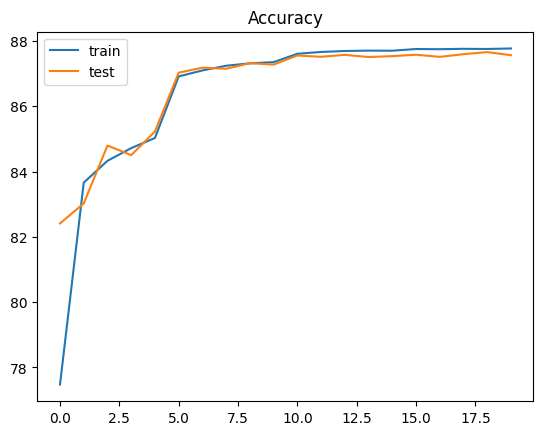

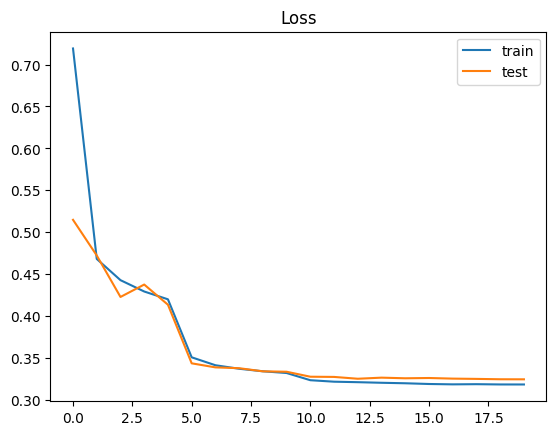

In [36]:
#Plot curves for train and test loss and accuracy train and test
import matplotlib.pyplot as plt

plt.plot(list(acc_dict.keys()), [acc_dict[i][0] for i in acc_dict.keys()], label='train')
plt.plot(list(acc_dict.keys()), [acc_dict[i][1] for i in acc_dict.keys()], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(list(loss_dict.keys()), [loss_dict[i][0] for i in loss_dict.keys()], label='train')
plt.plot(list(loss_dict.keys()), [loss_dict[i][1] for i in loss_dict.keys()], label='test')
plt.title('Loss')
plt.legend()
plt.show()



# Test model

In [33]:
model = ResNet_18().to(device)
model.load_state_dict(torch.load('model/ResNet-18/best_model.pth'))

<All keys matched successfully>

In [34]:
#display Confusion matrix
model.eval()


y_pred = []
y_true = []
with torch.no_grad():
    for X,Y in test_loader : 
        X,Y = X.to(device), Y.to(device)
        output = model(X).to(device)
        pred = output.argmax(dim=1, keepdim=True)
        y_pred.append(pred)
        y_true.append(Y)
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)



## Confusion Matrix

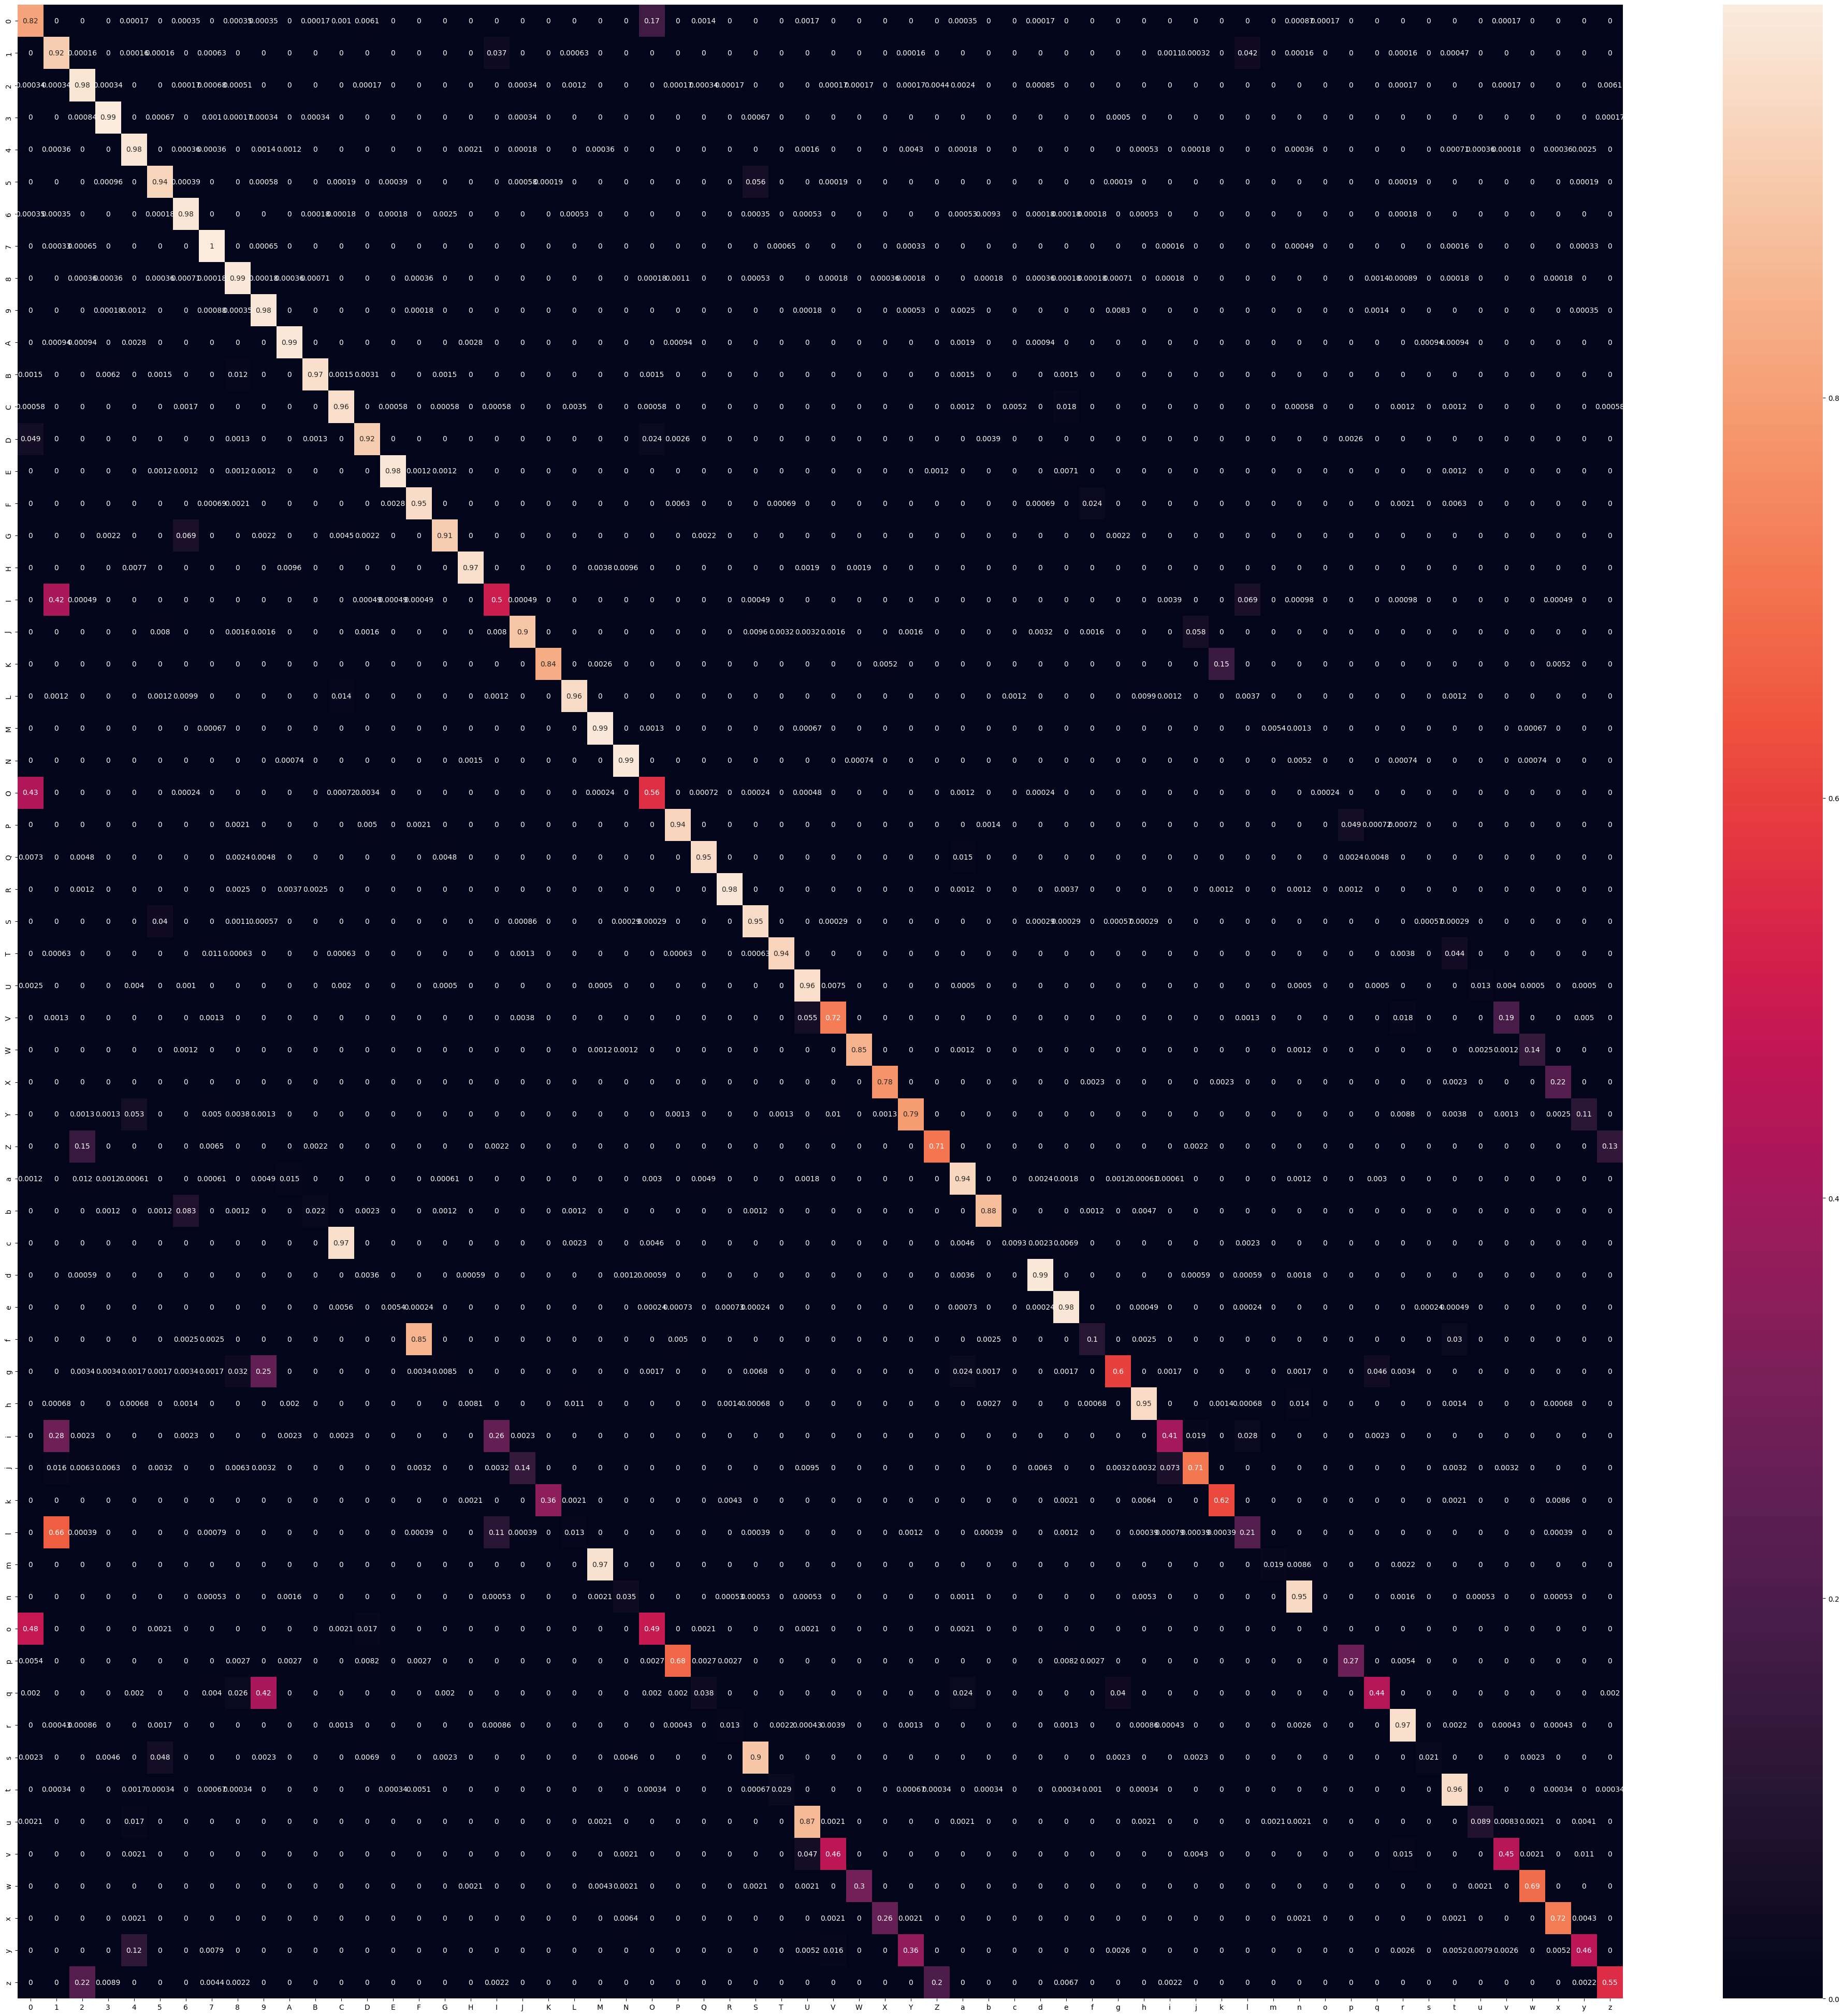

In [35]:
#display Confusion matrix

cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = [emnist_testset.classes[i] for i in range(62)], columns = [emnist_testset.classes[i]  for i in range(62)])
plt.figure(figsize = (50,50))
sns.heatmap(df_cm, annot=True)#, cmap='Blues')
plt.show()


### Convert the model with CoreML